In [ ]:
!pip install plot_keras_history

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
from tensorflow import keras
from collections import Counter
import collections
#from plot_keras_history import plot_history
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.initializers import random_uniform
from tensorflow.keras.layers import Flatten, Convolution1D, MaxPool1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from statistics import mean
#import CEEMDAN_LSTM as cl
#DATASET_NAME = 'Task1_P'

2022-01-23 23:44:10.128431: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
adam = Adam(learning_rate=0.001)
RMS = RMSprop(learning_rate=0.001)
sgd = SGD(learning_rate=0.1, decay=1e-6, momentum=0.9, nesterov=True) # Using Nesterov momentum


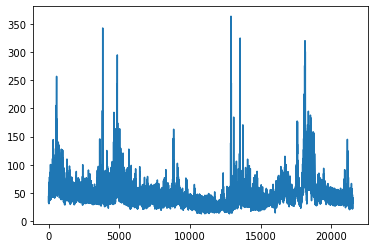

In [3]:
import pandas
import matplotlib.pyplot as plt
dataset = pandas.read_csv('Task1_P.csv', usecols=[4], engine='python')
plt.plot(dataset)
plt.show()

In [4]:
print(dataset.describe().transpose())

               count      mean        std    min    25%    50%    75%    max
Zonal Price  21528.0  48.59774  26.318477  12.52  33.67  43.11  54.92  363.8


In [5]:
import numpy as np
import pandas as pd
def data2matrix():
    df = pd.read_csv('Task1_P.csv')    
    #remove indexing in features 
    df = df.drop(['ZONEID'], axis=1)
    df = df.drop(['timestamp'], axis=1)

    #produce an numpy array
    df = df.dropna(how='any')  
    return df


In [6]:
from CEEMDAN import CEEMDAN
df=data2matrix()

S = df[['Forecasted Total Load']].to_numpy()
T= df[['Zonal Price']].to_numpy()
S.shape=(len(df),)
T.shape=(len(df),)
S=(S - min(S)) / (max(S) - min(S)) 
T=(T - min(T)) / (max(T) - min(T))
max_imf = -1
DTYPE = np.float64

# Signal options
N = 21520
tMin, tMax = 0, 2*np.pi
S = S.astype(DTYPE)


In [7]:
normalized_df=(df-df.min())/(df.max()-df.min())
df1=normalized_df[['Forecasted Total Load','Forecasted Zonal Load']]

In [8]:

######### Step 1: TIME SERIES DECOMPOSITION ###############
# Prepare and run EMD
emd = CEEMDAN()
emd.FIXE_H = 5
emd.nbsym = 2
emd.spline_kind = 'cubic'
emd.DTYPE = DTYPE

imfs = emd.emd(S, T, max_imf)


In [9]:
######### Step 2: IMFS CLASSIFICATION ###############
from pyentrp import entropy as ent

PE=[]

for i in range(len(imfs)):
    PE_value=ent.permutation_entropy(imfs[i], order=2, delay=1)
    PE.append(PE_value)


In [10]:
########Step 3: HIGH-FREQUENCY IMFS NOISE REDUCTION ###############
imfNo = imfs.shape[0]
length=len(imfs[0])
std_ts = np.std(imfs)
landa=std_ts*(np.sqrt((2*np.log(length))/(np.log(imfNo+1))))

imfs_free=[]
for i in range(len(imfs)):
    temp=[]
    for j in range(len(imfs[0])):
        if (np.abs(imfs[i][j]>=landa)):
            temp.append(imfs[i][j]*(imfs[i][j]-landa))
        else:
            temp.append(0)
    imfs_free.append(temp)


In [11]:
#########Step 4: RECONSTRUCTION ###############
reconstructed=[]
for i in range(len(imfs[0])):
    sum_IMF_high=0
    sum_IMF_low=0
    for j in range(len(imfs)):
        sum_IMF_high+=imfs[j][i]
        sum_IMF_low+=imfs_free[j][i]
    reconstructed.append(sum_IMF_high+sum_IMF_low)

print(len(reconstructed))
# Plot results
c = 1
r = int(np.ceil((imfNo+1)/c))


21528


In [ ]:
# Sample entropy
# -------------------------------
# You can also enter the imfs_df directly 
from sampen import sampen2
def sample_entropy(imfs_df=None): # imfs_df is pd.DataFrame
    # Calculate sample entropy with m=1,2 and r=0.1,0.2
    imfs = df.T.values
    sampen = []
    for i in imfs:
        for j in (0.1,0.2):
            sample_entropy = sampen2(list(i),mm=2,r=j,normalize=True)
            sampen.append(sample_entropy)
    
    # Output
    entropy_r1m1,entropy_r1m2,entropy_r2m1,entropy_r2m2 = [],[],[],[]
    for i in range(len(sampen)):
        if (i%2)==0: # r=0.1    
            entropy_r1m1.append(sampen[i][1][1])# m=1
            entropy_r1m2.append(sampen[i][2][1])# m=2
        else: # r=0.2
            entropy_r2m1.append(sampen[i][1][1])# m=1
            entropy_r2m2.append(sampen[i][2][1])# m=2
 
    # Plot     
    fig = plt.figure()
    x = list(range(0,len(imfs),1))
    plt.plot(x,entropy_r1m1,'k:H',label='m=1 r=0.1')
    plt.plot(x,entropy_r2m1,'b:D',label='m=1 r=0.2')
    plt.plot(x,entropy_r1m2,'c:s',label='m=2 r=0.1')
    plt.plot(x,entropy_r2m2,'m:h',label='m=2 r=0.2')
    plt.xlabel('IMFs')
    plt.ylabel('Sample Entropy')
    plt.legend()
    if file_name == '': fig.savefig(FIGURE_PATH+'Sample Entropy of %s IMFs.svg'%(file_name), bbox_inches='tight')
    plt.show()

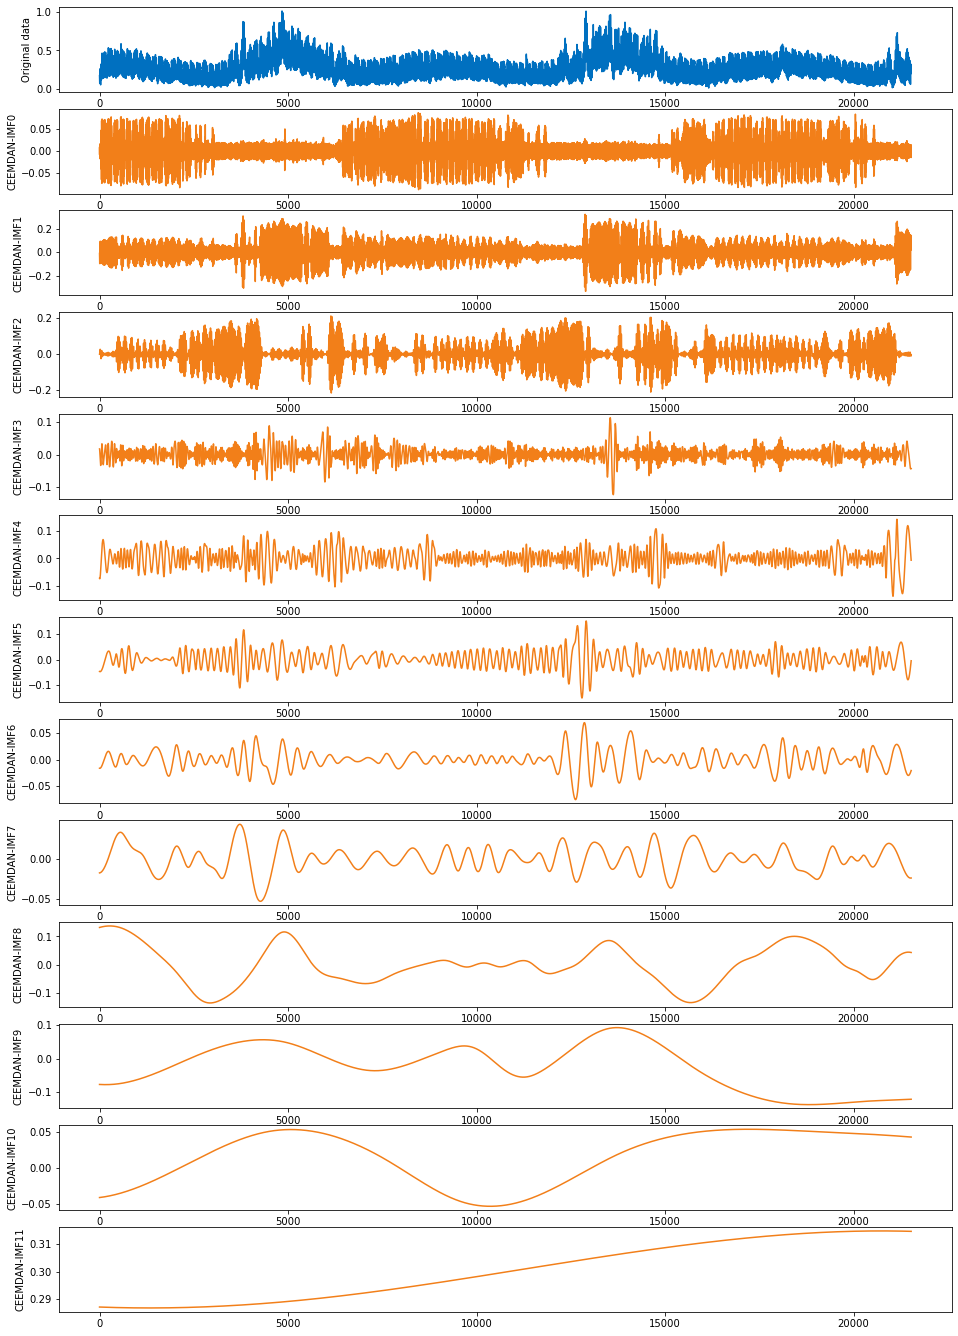

In [12]:
####################plotting signals#####################
# Plot original data
series_index = range(len(reconstructed))
fig = plt.figure(figsize=(16,2*imfNo))
plt.subplot(1+imfNo, 1, 1 )
plt.plot(series_index, reconstructed, color='#0070C0') #F27F19 orange #0070C0 blue
plt.ylabel('Original data')

# Plot IMFs
for i in range(imfNo):
    plt.subplot(1 + imfNo,1,2 + i)
    plt.plot(series_index, imfs[i, :], color='#F27F19')
    plt.ylabel(str.upper('ceemdan')+'-IMF'+str(i))

In [ ]:
sample_entropy() # SE

In [13]:

train_size=int(0.6*len(reconstructed))
validation_size=int(0.2*len(reconstructed))
test_size=int(0.2*len(reconstructed))


In [14]:
X = pd.DataFrame({'price':reconstructed})

In [16]:
X.head()

,price
0,0.173921
1,0.140569
2,0.116397
3,0.101127
4,0.091071


In [17]:
XX = df1.iloc[24:train_size].values
X_val=df1.iloc[train_size:train_size+validation_size].values
X_t=df1.iloc[train_size+validation_size:len(X)-24].values


In [18]:
# split into train, validation, and test sets

training_set = X.iloc[0:train_size].values
validation_set=X.iloc[train_size:train_size+validation_size+24].values
test_set = X.iloc[train_size+validation_size:len(X)].values


In [19]:

X_train = []
y_train = []

index_i=0
for i in range(24, len(training_set)):
    X_train.append(training_set[i-24:i,0])
    y_train.append(training_set[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train=np.concatenate((X_train, XX), axis=1)

In [20]:
X_train.shape,XX.shape,y_train.shape


((12892, 26), (12892, 2), (12892,))

In [21]:
DT=[]
for i in range(X_train.shape[0]):
    DT.append(1/24)


In [22]:
X_valid = []
y_valid = []
for i in range(24, len(validation_set)):
    X_valid.append(validation_set[i-24:i, 0])
    y_valid.append(validation_set[i, 0])
X_valid, y_valid = np.array(X_valid), np.array(y_valid)
X_valid=np.concatenate((X_valid, X_val), axis=1)


In [23]:
X_valid.shape,y_valid.shape

((4305, 26), (4305,))

In [24]:
DV=[]
for i in range(X_valid.shape[0]):
    DV.append(1/24)

In [25]:
X_test = []
y_test = []
for i in range(24, len(test_set)):
    X_test.append(test_set[i-24:i, 0])
    y_test.append(test_set[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test=np.concatenate((X_test, X_t), axis=1)


In [26]:
X_test.shape,y_test.shape


((4283, 26), (4283,))

In [27]:

# ===================================
# Train SAE model
# ===================================


input_data = keras.Input(shape=(X_train.shape[1],))

x = Dense(X.shape[1], activation='relu')(input_data)
############ Autoencoder 1 ######################
encoded1_1 = Dense(12)(x)
encoded1_2 = Dense(10)(encoded1_1)
encoded1_3 = Dense(8)(encoded1_2)
encoded1_4 = Dense(6)(encoded1_3)

decoded1_1 = Dense(6)(encoded1_4)
decoded1_2 = Dense(8)(decoded1_1)
encoded1_3 = Dense(10)(decoded1_2)
encoded1_4 = Dense(12)(encoded1_3)
z1 = Dense(X_train.shape[1], activation='sigmoid')(encoded1_4)

############ Autoencoder 2 ######################
encoded2_1 = Dense(12)(z1)
encoded2_2 = Dense(10)(encoded2_1)
encoded2_3 = Dense(8)(encoded2_2)
encoded2_4 = Dense(6)(encoded2_3)

decoded2_1 = Dense(6)(encoded2_4)
decoded2_2 = Dense(8)(decoded2_1)
encoded2_3 = Dense(10)(decoded2_2)
encoded2_4 = Dense(12)(encoded2_3)
z2 = Dense(X_train.shape[1], activation='sigmoid')(encoded2_4)

############ Autoencoder 3 ######################
encoded3_1 = Dense(12)(z2)
encoded3_2 = Dense(10)(encoded3_1)
encoded3_3 = Dense(8)(encoded3_2)
encoded3_4 = Dense(6)(encoded3_3)

decoded3_1 = Dense(6)(encoded3_4)
decoded3_2 = Dense(8)(decoded3_1)
encoded3_3 = Dense(10)(decoded3_2)
encoded3_4 = Dense(12)(encoded3_3)
z3 = Dense(X_train.shape[1], activation='sigmoid')(encoded3_4)

############ Autoencoder 4 ######################
encoded4_1 = Dense(12)(z3)
encoded4_2 = Dense(10)(encoded4_1)
encoded4_3 = Dense(8)(encoded4_2)
encoded4_4 = Dense(6)(encoded4_3)

decoded4_1 = Dense(6)(encoded4_4)
decoded4_2 = Dense(8)(decoded4_1)
encoded4_3 = Dense(10)(decoded4_2)
encoded4_4 = Dense(12)(encoded4_3)

z4 = Dense(X_train.shape[1], activation='sigmoid')(encoded4_4)
model = keras.Model(input_data, z4)

model.summary()

2022-01-23 23:47:36.694009: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-23 23:47:36.698392: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-23 23:47:36.751477: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.755GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97GiB/s
2022-01-23 23:47:36.751647: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-01-23 23:47:36.851419: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-01-23 23:47:36.851853: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.1

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 26)]              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 27        
_________________________________________________________________
dense_1 (Dense)              (None, 12)                24        
_________________________________________________________________
dense_2 (Dense)              (None, 10)                130       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 54        
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 42    

In [28]:
model.compile(optimizer='adadelta', loss='mse') # reporting the accuracy
history=model.fit(X_train, X_train,
          epochs=10,
          batch_size=32,
          validation_split=0.1)


2022-01-23 23:48:05.343904: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-23 23:48:05.363927: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3311075000 Hz


Epoch 1/10


2022-01-23 23:48:06.880114: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


363/363 [==============================] - 7s 15ms/step - loss: 0.0612 - val_loss: 0.0655
Epoch 2/10
363/363 [==============================] - 5s 13ms/step - loss: 0.0603 - val_loss: 0.0645
Epoch 3/10
363/363 [==============================] - 4s 12ms/step - loss: 0.0592 - val_loss: 0.0638
Epoch 4/10
363/363 [==============================] - 5s 13ms/step - loss: 0.0586 - val_loss: 0.0633
Epoch 5/10
363/363 [==============================] - 5s 13ms/step - loss: 0.0583 - val_loss: 0.0630
Epoch 6/10
363/363 [==============================] - 4s 12ms/step - loss: 0.0576 - val_loss: 0.0626
Epoch 7/10
363/363 [==============================] - 4s 12ms/step - loss: 0.0573 - val_loss: 0.0623
Epoch 8/10
363/363 [==============================] - 4s 12ms/step - loss: 0.0577 - val_loss: 0.0621
Epoch 9/10
363/363 [==============================] - 5s 12ms/step - loss: 0.0567 - val_loss: 0.0618
Epoch 10/10
363/363 [==============================] - 4s 12ms/step - loss: 0.0568 - val_loss: 0.0615


In [ ]:
x = modell.predict(X_train)

In [ ]:

# summarize history for loss
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper right')
plt.show()

In [ ]:

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))



In [ ]:
def EK_LSTM(y_train, yp_train, y_valid, yp_valid, Theta):
    sum_DT=0
    for i in range(len(y_train)):
        error=abs(yp_train[i]-y_train[i])/y_train[i]
        sum_DT+=DT[i]*(error-Theta)

    sum_DV=0
    for i in range(len(y_valid)):
        error=abs(yp_valid[i]-y_valid[i])/y_valid[i]
        sum_DV+=DV[i]*(error-Theta)

    EK_train=(len(y_train)/(len(y_train)+len(y_valid)))*sum_DT
    EK_valid=(len(y_valid)/(len(y_train)+len(y_valid)))*sum_DV

    EK=0.5*(EK_train[0]+EK_valid[0])
    
    return EK
    

In [ ]:
import math

def Z (y_actual, y_predict, alpha, D, Theta):
    sum_DT=0
    for i in range(len(y_actual)):
        error=abs(y_predict[i]-y_actual[i])/y_actual[i]
        sum_DT+=D[i]* math.exp(alpha[0]*(error-Theta))

    return sum_DT

In [ ]:
X_train.shape

In [ ]:
type(y_train)

In [ ]:
tf.__version__

In [ ]:
from tensorflow.keras.layers import LSTM
input_data = keras.Input(shape=(X_train.shape[1],))

x = Dense(X.shape[1], activation='relu')(input_data)
############ Autoencoder 1 ######################
encoded1_1 = Dense(12)(x)
encoded1_2 = Dense(10)(encoded1_1)
encoded1_3 = Dense(8)(encoded1_2)
encoded1_4 = Dense(6)(encoded1_3)

decoded1_1 = Dense(6)(encoded1_4)
decoded1_2 = Dense(8)(decoded1_1)
encoded1_3 = Dense(10)(decoded1_2)
encoded1_4 = Dense(12)(encoded1_3)
z1 = Dense(X_train.shape[1], activation='sigmoid')(encoded1_4)

############ Autoencoder 2 ######################
encoded2_1 = Dense(12)(z1)
encoded2_2 = Dense(10)(encoded2_1)
encoded2_3 = Dense(8)(encoded2_2)
encoded2_4 = Dense(6)(encoded2_3)

decoded2_1 = Dense(6)(encoded2_4)
decoded2_2 = Dense(8)(decoded2_1)
encoded2_3 = Dense(10)(decoded2_2)
encoded2_4 = Dense(12)(encoded2_3)
z2 = Dense(X_train.shape[1], activation='sigmoid')(encoded2_4)

############ Autoencoder 3 ######################
encoded3_1 = Dense(12)(z2)
encoded3_2 = Dense(10)(encoded3_1)
encoded3_3 = Dense(8)(encoded3_2)
encoded3_4 = Dense(6)(encoded3_3)

decoded3_1 = Dense(6)(encoded3_4)
decoded3_2 = Dense(8)(decoded3_1)
encoded3_3 = Dense(10)(decoded3_2)
encoded3_4 = Dense(12)(encoded3_3)
z3 = Dense(X_train.shape[1], activation='sigmoid')(encoded3_4)

############ Autoencoder 4 ######################
encoded4_1 = Dense(12)(z3)
encoded4_2 = Dense(10)(encoded4_1)
encoded4_3 = Dense(8)(encoded4_2)
encoded4_4 = Dense(6)(encoded4_3)

decoded4_1 = Dense(6)(encoded4_4)
decoded4_2 = Dense(8)(decoded4_1)
encoded4_3 = Dense(10)(decoded4_2)
encoded4_4 = Dense(12)(encoded4_3)
tf.keras.layers.Lambda(lambda x: tf.reshape(x, (-1, max_length, 6)),
#reshape = (X_train.shape[0], X_train.shape[1], 1)
z4 = Dense(X_train.shape[1], activation='sigmoid')(encoded4_4)
x = LSTM(units = 30, return_sequences = True)(z4)
x = Dropout(0.1)(x)

# Adding a second LSTM layer and some Dropout regularisation
x = LSTM(units = 30, return_sequences = True)(x)
x = Dropout(0.1)(x)

# Adding a third LSTM layer and some Dropout regularisation
x = LSTM(units = 30, return_sequences = True)(x)
x = Dropout(0.1)(x)

# Adding a fourth LSTM layer and some Dropout regularisation
x = LSTM(units = 30)(x)
x = Dropout(0.1)(x)
# Adding the output layer
x = Dense(units = 1)

model = keras.Model(input_data, x)

In [ ]:
from tensorflow.keras.layers import LSTM

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

alpha=[]
num_ensembles=2
for ensemble in range(num_ensembles):
    history1=model_2.fit(X_train, y_train, epochs = 20, batch_size = 64,validation_data=(X_valid, y_valid))
    # ===================================
    # Evaluate LSTM model using test data
    # ===================================
    pred_train=model_1.predict(X_train)
    pred_valid=model_1.predict(X_valid)
    pred_test=model_1.predict(X_test)

    Theta=0.05
    EK_M1=EK_LSTM(y_train, pred_train, y_valid, pred_valid, Theta)
    sum_DT=0
    for i in range(len(y_train)):
        error=abs(pred_train[i]-y_train[i])/y_train[i]
        sum_DT+=error-Theta

    mean_T=sum_DT/len(y_train)

    sum_DV=0
    for i in range(len(y_valid)):
        error=abs(pred_valid[i]-y_valid[i])/y_valid[i]
        sum_DV+=error-Theta

    mean_V=sum_DV/len(y_valid)
    
    alpha.append(0.5*(np.log(abs((1-EK_M1)/EK_M1))))
    
    ZT=Z(y_train, pred_train, alpha, DT, Theta)
    ZV=Z(y_valid, pred_valid, alpha, DV, Theta)
    for i in range(len(y_train)):
        DT[i]=(DT[i]/ZT)*math.exp(alpha[0]*(error-Theta))
    for i in range(len(y_valid)):
        DV[i]=(DT[i]/ZT)*math.exp(alpha[0]*(error-Theta))


W=[]
for ensemble in range(num_ensembles):
    W.append(alpha[ensemble]/sum(alpha))
    
p_final=sum(W)*sum(pred_train)


In [ ]:
try:
    import tensorflow as tf
    seq_len=20
    n_neurons=200
    n_layers=2
    n_steps=seq_len-1
    n_inputs=4
    n_outputs=4
    learning_rate=0.001
    n_epochs=100
    
    layers=[tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
            for layer in range(n_layers)]
    
    x_GRU=tf.placeholder(tf.float32, [None,n_steps,n_inputs])
    y_GRU=tf.placeholder(tf.float32, [None,n_inputs])
    
    multi_layer_cell=tf.contrib.rnn.MultiRNNCell(layers)
    rnn_outputs,states=tf.nn.dynamic_rnn(multi_layer_cell,x_GRU,DTYPE=tf.float32)
    stacked_rnn_outputs=tf.reshape(rnn_outputs,[-1,n_neurons])
    stacked_outputs=tf.layers.Dense(stacked_rnn_outputs,n_outputs)
    outputs=tf.reshape(stacked_outputs, [-1,n_steps,n_outputs])
    outputs=outputs[:,n_steps-1]

except: pass

In [ ]:
try:
    loss=tf.reduce_mean(tf.square(outputs-y_GRU))
    optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op=optimizer.minimize(loss)
    
    with tf.Session() as sess:
        alpha=[]
        num_ensembles=2
        for ensemble in range(num_ensembles):
            sess.run(tf.global_variables_initializer())
            for iteration in range(n_epochs):
               sess.run(training_op, feed_dict={x_GRU: X_train, y_GRU: y_train})
            pred_test=sess.run(outputs,feed_dict={x_GRU:X_test})
            # ===================================
            # Evaluate LSTM model using test data
            # ===================================
            pred_train=sess.run(outputs,feed_dict={x_GRU:X_train})
            pred_valid=sess.run(outputs,feed_dict={x_GRU:X_valid})
            pred_test=sess.run(outputs,feed_dict={x_GRU:X_test})
        
            Theta=0.05
            EK_M1=EK_LSTM(y_train, pred_train, y_valid, pred_valid, Theta)
            sum_DT=0
            for i in range(len(y_train)):
                error=abs(pred_train[i]-y_train[i])/y_train[i]
                sum_DT+=error-Theta
        
            mean_T=sum_DT/len(y_train)
        
            sum_DV=0
            for i in range(len(y_valid)):
                error=abs(pred_valid[i]-y_valid[i])/y_valid[i]
                sum_DV+=error-Theta
        
            mean_V=sum_DV/len(y_valid)
            
            alpha.append(0.5*(np.log(abs((1-EK_M1)/EK_M1))))
            
            ZT=Z(y_train, pred_train, alpha, DT, Theta)
            ZV=Z(y_valid, pred_valid, alpha, DV, Theta)
            for i in range(len(y_train)):
                DT[i]=(DT[i]/ZT)*math.exp(alpha[0]*(error-Theta))
            for i in range(len(y_valid)):
                DV[i]=(DT[i]/ZT)*math.exp(alpha[0]*(error-Theta))
        
        
        W=[]
        for ensemble in range(num_ensembles):
            W.append(alpha[ensemble]/sum(alpha))
            
        p_final=sum(W)*sum(pred_train)
        
        

except: pass

In [ ]:
from keras.layers import LSTM


model_1 = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model_1.add(LSTM(units = 30, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model_1.add(Dropout(0.1))
# Adding a second LSTM layer and some Dropout regularisation
model_1.add(LSTM(units = 30, return_sequences = True))
model_1.add(Dropout(0.1))
# Adding a third LSTM layer and some Dropout regularisation
model_1.add(LSTM(units = 30, return_sequences = True))
model_1.add(Dropout(0.1))
# Adding a fourth LSTM layer and some Dropout regularisation
model_1.add(LSTM(units = 30))
model_1.add(Dropout(0.1))
# Adding the output layer
model_1.add(Dense(units = 1))

# Compiling the RNN
model_1.compile(optimizer = 'adam', loss = 'mean_squared_error')

alpha=[]
num_ensembles=2
for ensemble in range(num_ensembles):
    history1=model_1.fit(X_train, y_train, epochs = 20, batch_size = 64,validation_data=(X_valid, y_valid))
    # ===================================
    # Evaluate LSTM model using test data
    # ===================================
    pred_train=model_1.predict(X_train)
    pred_valid=model_1.predict(X_valid)
    pred_test=model_1.predict(X_test)

    Theta=0.05
    EK_M1=EK_LSTM(y_train, pred_train, y_valid, pred_valid, Theta)
    sum_DT=0
    for i in range(len(y_train)):
        error=abs(pred_train[i]-y_train[i])/y_train[i]
        sum_DT+=error-Theta

    mean_T=sum_DT/len(y_train)

    sum_DV=0
    for i in range(len(y_valid)):
        error=abs(pred_valid[i]-y_valid[i])/y_valid[i]
        sum_DV+=error-Theta

    mean_V=sum_DV/len(y_valid)
    
    alpha.append(0.5*(np.log(abs((1-EK_M1)/EK_M1))))
    
    ZT=Z(y_train, pred_train, alpha, DT, Theta)
    ZV=Z(y_valid, pred_valid, alpha, DV, Theta)
    for i in range(len(y_train)):
        DT[i]=(DT[i]/ZT)*math.exp(alpha[0]*(error-Theta))
    for i in range(len(y_valid)):
        DV[i]=(DT[i]/ZT)*math.exp(alpha[0]*(error-Theta))


W=[]
for ensemble in range(num_ensembles):
    W.append(alpha[ensemble]/sum(alpha))
    
p_final=sum(W)*sum(pred_train)


In [ ]:
# summarize history for loss
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper right')
plt.show()


In [ ]:
def plot_line(x, y, b,R2): 
	# plotting the actual points as scatter plot 
	plt.scatter(x, y, color = "orange", 
			marker = "o", s = 50) 

	# predicted response vector 
	y_pred = b[0] + b[1]*x
	
	plt.rcParams["figure.figsize"] = (7,7)
	# plotting the regression line 
	plt.plot(x, y_pred, color = "black")
	plt.text(3.5, 12.7, r'$R^2$=$R2$', fontsize=10)


	#putting labels
    #plt.title('ANFIS vs. ANFIS_ABC', fontweight='bold')
	plt.xlabel('Actual BI') 
	plt.ylabel('Predicted BI') 
	plt.title('Test')
	# function to show plot 
	plt.show()


In [ ]:
def estimate_coef(x, y): 
	# number of observations/points 
	n = np.size(x) 

	# mean of x and y vector 
	m_x, m_y = np.mean(x), np.mean(y) 

	# calculating cross-deviation and deviation about x 
	SS_xy = np.sum(y*x) - n*m_y*m_x 
	SS_xx = np.sum(x*x) - n*m_x*m_x 

	# calculating regression coefficients 
	b_1 = SS_xy / SS_xx 
	b_0 = m_y - b_1*m_x 

	return(b_0, b_1) 


In [ ]:
def R_square(y,y_p):
    
    correlation_matrix = np.corrcoef(y, y_p)
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    
    return r_squared

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
def RSME(y,y_p):
    rms = sqrt(mean_squared_error(y, y_p))
    
    return rms


In [ ]:
from sklearn.metrics import mean_absolute_error

def MAE(y,y_p):
    mae = sqrt(mean_absolute_error(y, y_p))
    
    return mae


In [ ]:
def SI(y,y_p):
    rms = sqrt(mean_squared_error(y, y_p))
    sum=0
    for i in y:
        sum=sum+sqrt(rms)/i
    
    return sum/len(y)


In [ ]:

b = estimate_coef(y_test, pred_test) 
print("Estimated coefficients:\nb_0 = {} \ \nb_1 = {}".format(b[0], b[1])) 

# plotting regression line 
plot_line(y_test, pred_test, b,R_square(y_test,pred_test.T))
print('R2:',R_square(y_test,pred_test.T))

print ('RSME:',RSME(y_test,pred_test))
print ('MAE:',MAE(y_test,pred_test))
print ('SI:',SI(y_test,pred_test))